## Vanilla GAN with Fashion MNIST Dataset

This project will focus on building and training a simple GAN architecture with Fashion MNIST dataset. The architecture is referred as a "Vanilla" GAN, it is similar to the architecture that was proposed by Ian Goodfellow et al. Kindy refer this <a href="https://arxiv.org/abs/1406.2661" target="_blank">link</a> for more information.

In [1]:
# import libraries
import os
import time
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
# initialize variables
device: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epoch_number: int = 100
latent_dimension: int = 100
batch_size: int = 32
discriminator_learning_rate: float = 0.0002
generator_learning_rate: float = 0.0002
checkpoint_path: str = os.path.join('model_checkpoint', 'vanilla_gan_fashion_mnist')
image_height: int = 28
image_width: int = 28
channel_number: int = 1

In [3]:
# functions for basic usage
def plot_generator_image(model):
    fixed_noise = torch.randn(int(batch_size / 2), latent_dimension)
    model.eval()

    with torch.no_grad():
        images = model(fixed_noise.to(device))
        images = images.detach().cpu().view((images.shape[0], 28, 28))

    plt.figure(figsize = (20, 4))

    num_row = 2
    num_col = int(images.shape[0] / num_row)

    for i, image in enumerate(images):
        plt.subplot(num_row, num_col, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')

    plt.show()

def generate_images_result(model):
    noise = torch.randn(batch_size, latent_dimension)
    model.eval()

    with torch.no_grad():
        images = model(noise.to(device))
        images = images.cpu().view((images.shape[0]), 28, 28)

    nbr_row = 4
    nbr_col = int(noise.shape[0] / nbr_row)

    plt.figure(figsize = (25, 10))

    for i, image in enumerate(images):
        plt.subplot(nbr_row, nbr_col, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')  

    plt.show()

def plot_loss_result(metrics, ylabel = None, ylim = None, metric_name = None, color = None):
    fig, ax = plt.subplots(figsize = (18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color = color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, epoch_number - 1])
    plt.ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block = False)
    plt.close()

#### 1. Dataset Setup
Utilize the newly created transform_v2 for the FashionMNIST dataset. The dataset will be downloaded to the specified root directory if it's not already present. Adjust the root directory as needed.

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean = [0.5], std = [0.5])
])

training_dataset = datasets.FashionMNIST(
    root = '../../dataset',
    train = True,
    download = True,
    transform = transform
)

training_dataloader = DataLoader(
    dataset = training_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 1
)

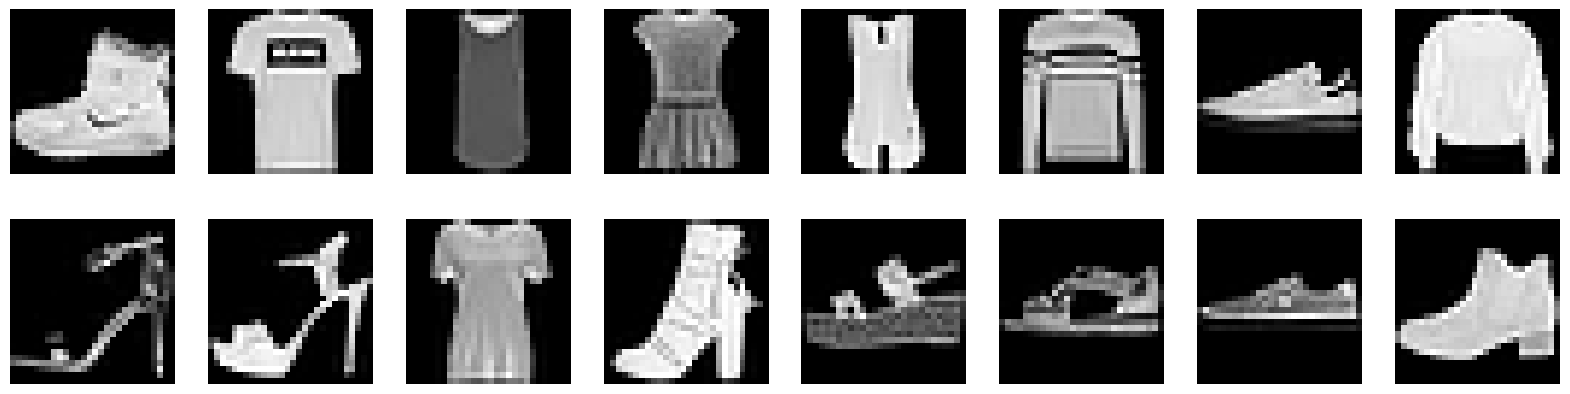

In [5]:
# visualization
plt.figure(figsize = (20, 5))

row_number, col_number = 2, 8

for i in range(row_number * col_number):
    ax = plt.subplot(row_number, col_number, i + 1)
    # resize (1, 28, 28) to (28, 28)
    plt.imshow(training_dataset[i][0].view((28, 28)), cmap = 'gray')
    plt.axis("off")

#### 2. Network Architecture Creation
Generator Network - The generator network is designed to convert a noise vector into a 2-dimensional image. It is a combination of dense and fully connected layers within the architecture. The generator network comprises `Linear` and `LeakyReLU` layers with an increased number of features. The utilization of `LeakyReLU` instead of `ReLU` is preferred due to its stability in training GANs. Notably, LeakyReLU was not initially incorporated into the GAN architecture in earlier papers. The activation function of the output layer is `Tanh`. Through experimentation over the years, researchers and practitioners have identified optimal practices for training GANs. 

The Fashion MNIST dataset consists of grayscale images with a resolution of 28 x 28 pixels, we expect generator network generates such images.  The final `Linear` layer has shape (1, 784), generator network will reshape these outputs (while taking the batch size into consideration) into (1, 28, 28) images by using `view()` function. Finally, the reshaped output (generated image) is returned. 

Discriminator network - It is very simple binary classification network. In this architecture, `Linear` layers will be used rather than convolutional layers. The input will be reshaped (flatten) first. This network is exclusively designed for solving a binary classification problem, the activation function of the output layer will be `Sigmoid`.

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(), # tanh is used for output images with pixel values in the range [-1, 1]
        )

    def forward(self, x):
        # convert (batch, 784) to (batch, 1, 28, 28)
        return self.generator(x).view(
            -1, 
            channel_number, 
            image_height, 
            image_width
        )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_size = channel_number * image_height * image_width
        self.discriminator = nn.Sequential(
            nn.Linear(self.input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # sigmoid is used for binary classification
        )

    def forward(self, x):
        # convert (batch, 28, 28) to (batch, 784)
        x = x.view(-1, 784)
        return self.discriminator(x)

In [7]:
generator = Generator(latent_dim = latent_dimension).to(device)
print(generator)

total_params = sum(p.numel() for p in generator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)
1,506,448 total parameters.
1,506,448 training parameters.


In [8]:
discriminator = Discriminator().to(device)
print(discriminator)

total_params = sum(p.numel() for p in discriminator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

784
Discriminator(
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
533,505 total parameters.
533,505 training parameters.


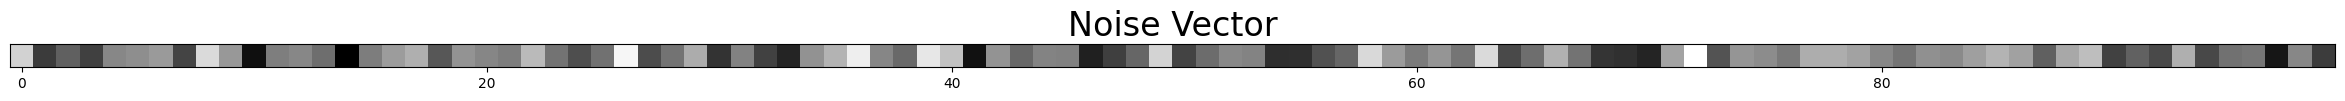

In [9]:
# create random noice and visualize it
noise = torch.randn(1, latent_dimension)

plt.figure(figsize = (30, 10))
plt.imshow(noise, cmap = 'gray')
plt.yticks([])
plt.title("Noise Vector", fontsize = 24)
plt.show()

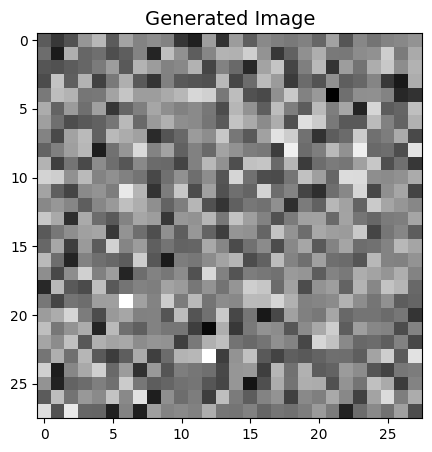

In [10]:
# generate fake image and visualize it
generated_image = generator(noise.to(device))
generated_image = generated_image.detach().cpu().view(28, 28)

plt.figure(figsize = (5, 5))
plt.imshow(generated_image, cmap = 'gray')
plt.title('Generated Image', fontsize = 14)
plt.show()

In [11]:
optimizer_generator = optim.Adam(
    generator.parameters(), 
    lr = generator_learning_rate,
    betas = (0.5, 0.999)
)

optimizer_discriminator = optim.Adam(
    discriminator.parameters(), 
    lr = discriminator_learning_rate,
    betas = (0.5, 0.999)
)

In [12]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

num_versions = len(os.listdir(checkpoint_path)) + 1
ckpt_version_dir = checkpoint_path + '/version_' + str(num_versions)

os.makedirs(ckpt_version_dir)

In [13]:
generator_ckpt = os.path.join(ckpt_version_dir, 'generator'+'.pth')
discriminatr_ckpt = os.path.join(ckpt_version_dir, 'discriminator'+'.pth')

In [14]:
bce = nn.BCELoss()

def loss_func(y_true, y_pred):
    loss = bce(y_pred, y_true)
    return loss

#### Model Training

In [15]:
def gan_training(real_image = None):
    # clear gradients of all optimizers
    optimizer_generator.zero_grad()
    optimizer_discriminator.zero_grad()

    # generate labels for discriminator network - 1 for real data and 0 for fake data
    labels = torch.cat(
        (torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim = 0
    ).to(device)
    # generate labels for generator network - 1 for real data
    misleading_labels = torch.ones(batch_size, 1).to(device)

    # create random noise
    noise = torch.randn(
        batch_size,
        latent_dimension
    ).to(device)

    # training discriminator network
    # generate fake images
    fake_image = generator(noise)

    # predicte labels from discriminator for real images
    y_pred_real = discriminator(real_image)
    # predicte labels from discriminator for fake images.
    y_pred_fake = discriminator(fake_image)

    # concatenate prediction for real and fake data
    y_pred_discriminator = torch.cat((y_pred_real, y_pred_fake), dim = 0)

    # compute the discriminator loss
    discriminator_loss = loss_func(labels, y_pred_discriminator)

    # discriminator network step
    discriminator_loss.backward()
    optimizer_discriminator.step()

    # training generator network
    # generate fake images
    fake_image = generator(noise)

    # predicte labels from discriminator for fake images
    y_pred_fake = discriminator(fake_image)

    # compute the generator loss
    generator_loss = loss_func(misleading_labels, y_pred_fake)

    # generator network step
    generator_loss.backward()
    optimizer_generator.step()

    return discriminator_loss, generator_loss

100%|██████████| 1875/1875 [00:10<00:00, 172.57it/s]




Training time for epoch 1 is 10.94281005859375 sec
Generator loss: 1.353, Discriminator loss: 0.519


100%|██████████| 1875/1875 [00:10<00:00, 183.82it/s]




Training time for epoch 2 is 10.316892623901367 sec
Generator loss: 1.269, Discriminator loss: 0.561


100%|██████████| 1875/1875 [00:10<00:00, 186.55it/s]




Training time for epoch 3 is 10.174542903900146 sec
Generator loss: 1.110, Discriminator loss: 0.601


100%|██████████| 1875/1875 [00:10<00:00, 182.70it/s]




Training time for epoch 4 is 10.38338327407837 sec
Generator loss: 1.077, Discriminator loss: 0.603


100%|██████████| 1875/1875 [00:10<00:00, 179.33it/s]




Training time for epoch 5 is 10.617028951644897 sec
Generator loss: 1.017, Discriminator loss: 0.621


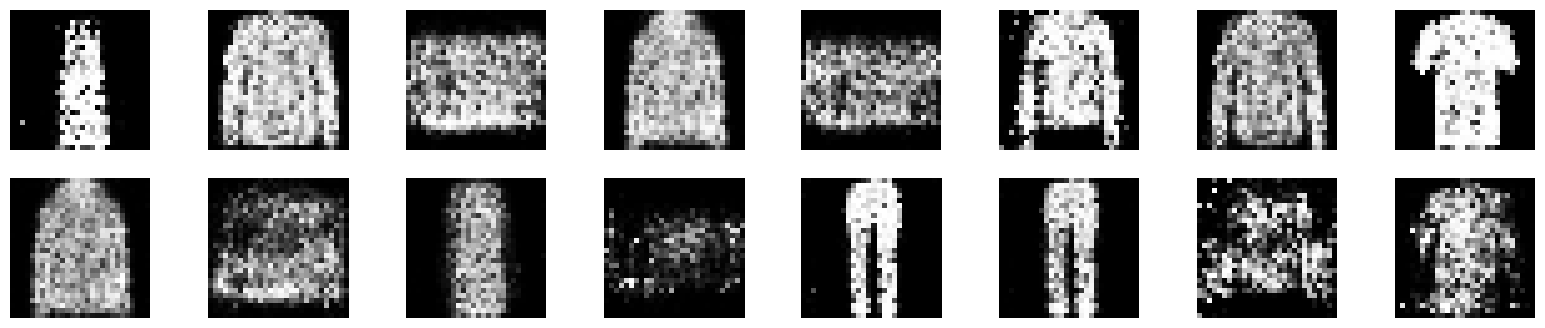

100%|██████████| 1875/1875 [00:10<00:00, 183.58it/s]




Training time for epoch 6 is 10.334389448165894 sec
Generator loss: 0.968, Discriminator loss: 0.632


100%|██████████| 1875/1875 [00:10<00:00, 187.36it/s]




Training time for epoch 7 is 10.128436803817749 sec
Generator loss: 0.955, Discriminator loss: 0.634


100%|██████████| 1875/1875 [00:10<00:00, 173.50it/s]




Training time for epoch 8 is 10.923789262771606 sec
Generator loss: 0.930, Discriminator loss: 0.638


100%|██████████| 1875/1875 [00:10<00:00, 179.30it/s]




Training time for epoch 9 is 10.580077886581421 sec
Generator loss: 0.896, Discriminator loss: 0.647


100%|██████████| 1875/1875 [00:10<00:00, 180.69it/s]




Training time for epoch 10 is 10.502391576766968 sec
Generator loss: 0.883, Discriminator loss: 0.650


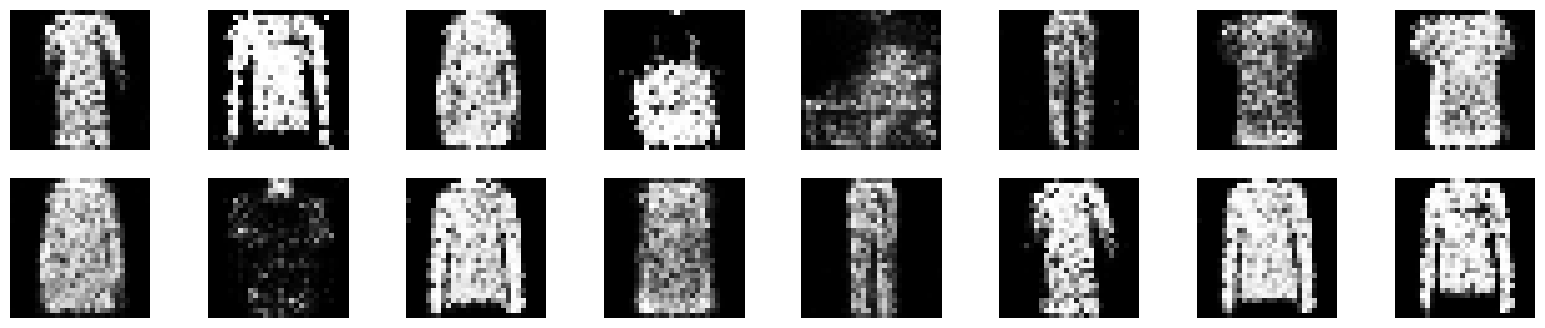

100%|██████████| 1875/1875 [00:11<00:00, 168.98it/s]




Training time for epoch 11 is 11.230289697647095 sec
Generator loss: 0.880, Discriminator loss: 0.648


100%|██████████| 1875/1875 [00:11<00:00, 159.32it/s]




Training time for epoch 12 is 11.96549940109253 sec
Generator loss: 0.880, Discriminator loss: 0.648


100%|██████████| 1875/1875 [00:12<00:00, 148.96it/s]




Training time for epoch 13 is 12.717865467071533 sec
Generator loss: 0.879, Discriminator loss: 0.646


100%|██████████| 1875/1875 [00:10<00:00, 178.52it/s]




Training time for epoch 14 is 10.620200395584106 sec
Generator loss: 0.881, Discriminator loss: 0.644


100%|██████████| 1875/1875 [00:11<00:00, 165.07it/s]




Training time for epoch 15 is 11.51919937133789 sec
Generator loss: 0.879, Discriminator loss: 0.645


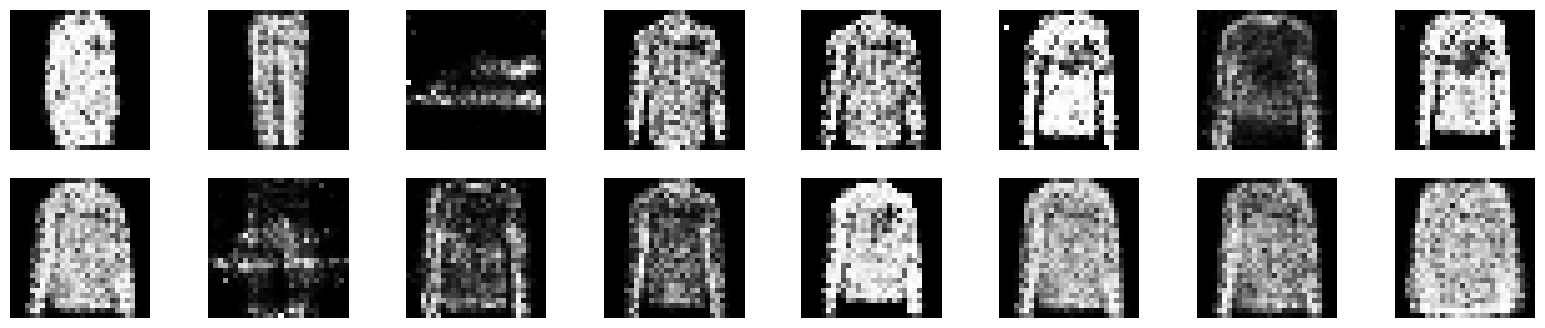

100%|██████████| 1875/1875 [00:12<00:00, 149.18it/s]




Training time for epoch 16 is 12.71673035621643 sec
Generator loss: 0.880, Discriminator loss: 0.643


100%|██████████| 1875/1875 [00:13<00:00, 134.08it/s]




Training time for epoch 17 is 14.107651710510254 sec
Generator loss: 0.882, Discriminator loss: 0.640


100%|██████████| 1875/1875 [00:12<00:00, 148.86it/s]




Training time for epoch 18 is 12.71743893623352 sec
Generator loss: 0.883, Discriminator loss: 0.640


100%|██████████| 1875/1875 [00:11<00:00, 156.46it/s]




Training time for epoch 19 is 12.10495138168335 sec
Generator loss: 0.883, Discriminator loss: 0.641


100%|██████████| 1875/1875 [00:12<00:00, 149.68it/s]




Training time for epoch 20 is 12.66582465171814 sec
Generator loss: 0.885, Discriminator loss: 0.638


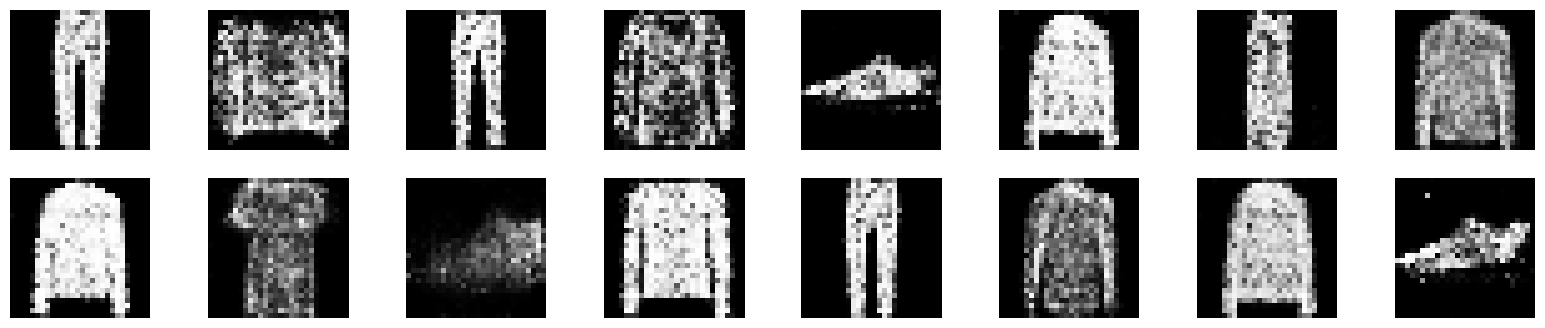

  0%|          | 0/1875 [00:02<?, ?it/s]


In [16]:
generator_loss = []
discriminator_loss = []

for epoch in range(epoch_number):
    # set training mode
    generator.train()
    discriminator.train()

    start = time.time()
    discriminator_loss_list, generator_loss_list = [], []

    for idx, data in tqdm(enumerate(training_dataloader), total = int(len(training_dataloader))):
        image_batch, label = data
        image_batch = image_batch.to(device)

        discriminator_loss_batch, generator_loss_batch = gan_training(image_batch)
        
        discriminator_loss_list.append(discriminator_loss_batch)
        generator_loss_list.append(generator_loss_batch)

    # save check point every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(generator, generator_ckpt)
        torch.save(discriminator, discriminatr_ckpt)

    epoch_discriminator_loss = sum(discriminator_loss_list) / len(discriminator_loss_list)
    epoch_generator_loss = sum(generator_loss_list) / len(generator_loss_list)

    discriminator_loss.append(epoch_discriminator_loss.detach().cpu())
    generator_loss.append(epoch_generator_loss.detach().cpu())
    
    print('\n')
    print(f"Training time for epoch {epoch + 1} is {time.time() - start} sec")
    print(f"Generator loss: {epoch_generator_loss:.3f}, Discriminator loss: {epoch_discriminator_loss:.3f}")

    # display every 5 epochs
    if (epoch + 1) % 5 == 0:
        plot_generator_image(generator)


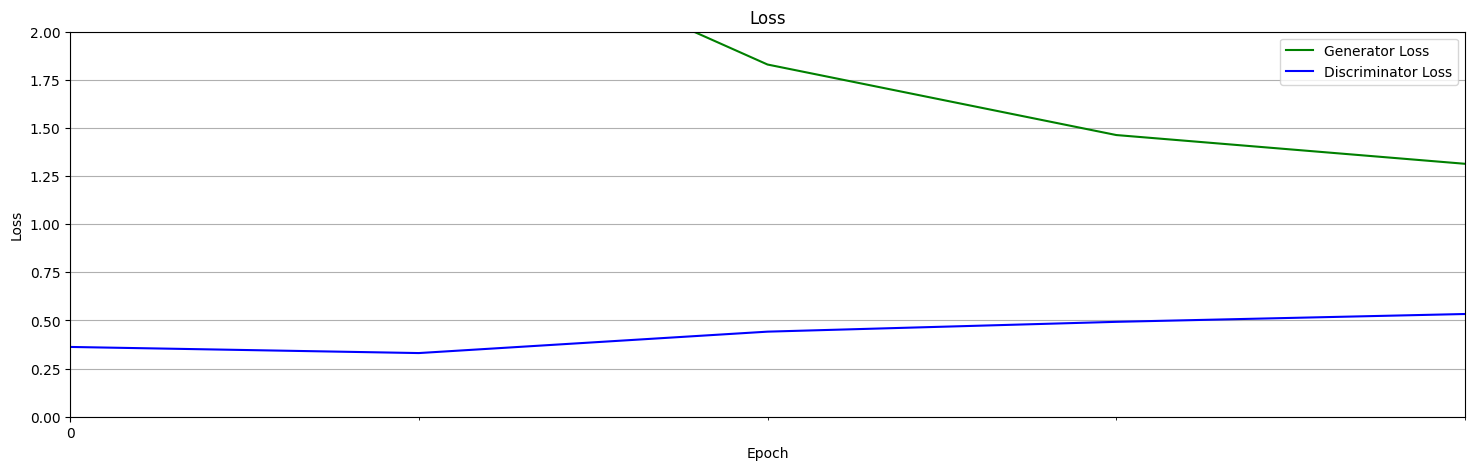

In [ ]:
plot_loss_result([generator_loss, discriminator_loss], ylabel = "Loss", ylim = [0, 2],
    metric_name = ["Generator Loss", "Discriminator Loss"], color = ["g", "b"])

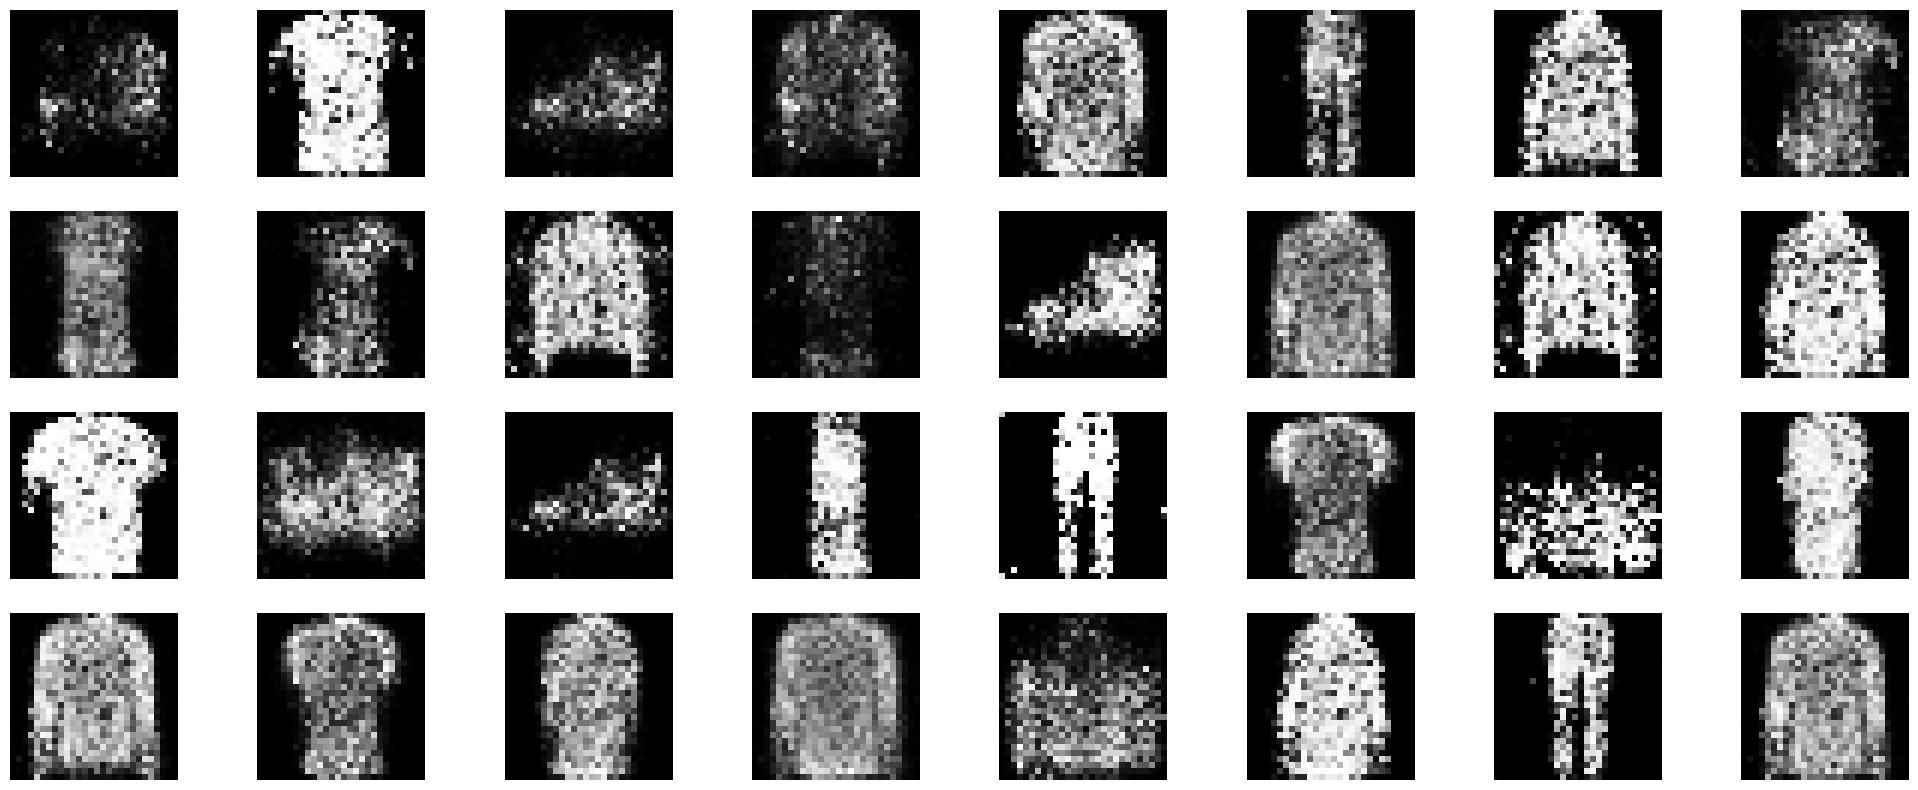

In [ ]:
trained_generator = torch.load(generator_ckpt)
generate_images_result(trained_generator)